# Data Coverage
Summary:

* One unexpected complexity I discovered was that the temporal resolution of station measurements can change in strange ways.This matters because we need to know the measurement resolution in order to exclude data with poor intra-day coverage. If a mean temperature was based on only daylight hours, for example, it would have a large upward bias compared to a full day average. I expected that over decades, some stations would switch from low resolution 6- or 3-hourly measurements up to 1-hourly resolution, but it turns out they can switch back and forth. I think we'll have to use some changepoint detection methods to pick out those transitions.
* Related to the above, some stations appear to rely on manual data reporting, and only log data during business hours! It is theoretically possible to use this data for analyzing trends as long as that bias is consistent over time. But for now I plan to omit those stations unless we really have no other choice. We'll know whether that is necessary by the end of this week, when I finish the availability analysis.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import altair as alt

import src.data.reshape as rs

In [4]:
# supplement default JS plots with backup static PNGs.
# This lets them render on GitHub
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [5]:
pd.options.display.max_columns= 50

In [6]:
gsod = rs.get_gsod()

In [7]:
station_meta = rs.get_station_metadata()

In [8]:
station_meta = station_meta.loc[station_meta['distance_km'] <= 50]
station_meta.shape

(344, 13)

In [9]:
station_meta = station_meta.set_index(['usaf', 'wban'])

In [10]:
#gsod = gsod.merge(stations[['usaf', 'wban', 'nearest_city']], on=['usaf', 'wban'])
gsod.head(3)

,timestamp,usaf,wban,temp_f_mean,temp_count,dew_point_f_mean,dew_point_count,sea_level_pressure_mbar_mean,sea_level_pressure_count,pressure_mbar_mean,pressure_count,visbility_miles_mean,visbility_count,wind_speed_knots_mean,wind_speed_count,temp_f_max,temp_max_measurement_type,temp_f_min,temp_min_measurement_type,precipitation_total_inches,precipitation_measurement_type,snow_depth_inches,had_rain,had_snow_ice,had_hail
0,1985-01-26,691484,99999,38.099998,5,37.400002,5,NaN,0,NaN,0,4.8,5,5.2,5,39.200001,*,37.400002,*,NaN,NaN,0.8,1,0,0
1,1985-01-27,691484,99999,34.500000,5,30.600000,5,NaN,0,NaN,0,4.9,5,3.8,5,39.200001,*,30.200001,*,NaN,NaN,NaN,1,1,0
2,1985-01-28,691484,99999,26.900000,17,20.100000,17,NaN,0,NaN,0,5.9,17,2.5,17,33.799999,*,19.400000,*,0.0,I,NaN,0,0,0


In [11]:
station_ids = gsod[['usaf', 'wban']].drop_duplicates()
station_ids.shape

(223, 2)

In [12]:
gsod = gsod.set_index(['usaf', 'wban']).sort_index()

In [13]:
random_station_id = tuple(station_ids.sample(1, random_state=1).to_numpy()[0])
# see below station for example of operating style with ~15 hourly observations per day.
# They don't report data between 9pm and 8am!
# This produces a massive diurnal bias to mean temperatures.
# But if we care ONLY about trends, it is OK as long as it stays consistent.
# I assume this reporting pattern is responsible for all stations with
# temp_count values clustered around 15.
#random_station_id = ('724937', '23289')

In [14]:
station_meta.loc[random_station_id,:]

name                         ALAMEDA(USN)
country                                US
state                                  CA
call                                 KNGZ
latitude                           37.733
longitude                        -122.317
elevation_ft                          4.0
nominal_begin_date    1973-01-01 00:00:00
nominal_end_date      1997-01-02 00:00:00
nearest_city                San Francisco
distance_km                     10.139449
Name: (745060, 23239), dtype: object

In [15]:
random_station = gsod.loc[random_station_id,:].set_index('timestamp').sort_index()
#random_station.head()

<AxesSubplot:xlabel='timestamp'>

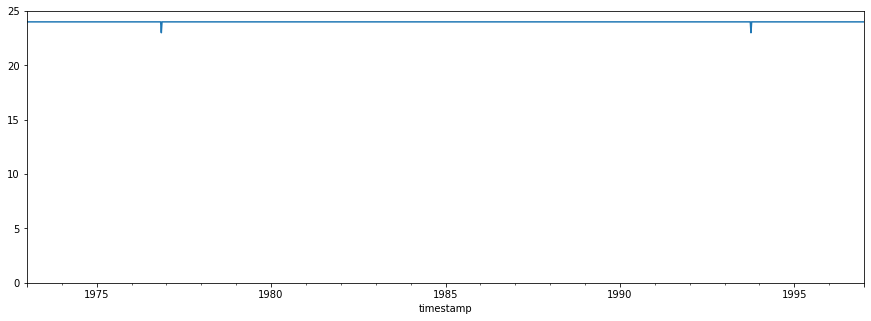

In [16]:
random_station.resample('7d')['temp_count'].max().plot(figsize=(15,5), ylim=(0,25))

Discovered a fair amount of complexity in the `temp_count` timeseries:
* changes over time (as expected)
* not always stable - can go from 8 to 24 to 4 and back to 8. (not expected)
* some stations have random distributions of max counts \[This is because some stations seem to be manually reported: no data overnight.\]
To do:
- [ ] make func to plot data coverage of a station
- [ ] plot each city's stations
- [ ] make func to summarize outage periods

<AxesSubplot:xlabel='timestamp'>

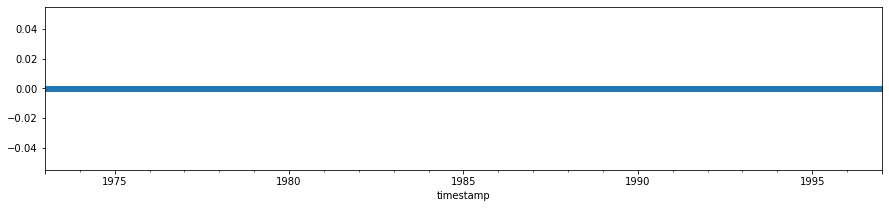

In [17]:
random_station['temp_f_mean'].asfreq('D').isna().astype(np.uint8).plot(linestyle='none', marker='|', figsize=(15,3), markersize=5)

In [18]:
data_periods = gsod.groupby(['usaf', 'wban'])['timestamp'].agg(['min', 'max', 'count'])

In [19]:
station_meta['nominal_duration_years'] = station_meta.loc[:, 'nominal_end_date'].sub(station_meta.loc[:, 'nominal_begin_date']).dt.days / 365.25
station_meta.head(3)

,,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,
690320,99999,BLAINE HARBOR MUNI,US,WA,WA09,48.983,-122.733,21.0,1992-04-16,1994-03-03,Vancouver,43.664391,1.878166
691484,99999,FAIRCHILD AFB / EXERCISE,US,WA,NaN,47.617,-117.667,750.4,1984-07-09,1995-05-02,Spokane,18.641562,10.811773
720046,99999,NEWHALL,US,CA,K3A6,34.370,-118.570,427.0,2004-02-24,2011-09-05,Los Angeles,46.355812,7.529090


In [20]:
# Aggressive Subset
threshold_years = 10
threshold_date = '1900-01-01'
station_meta.query("(nominal_duration_years > @threshold_years or nominal_begin_date < @threshold_date)").shape

(235, 12)

In [21]:
shortlist_meta = data_periods.query("count > (@threshold_years*0.8*365.25) or min < @threshold_date")
shortlist_meta.shape

(190, 3)

In [22]:
shortlist_meta['time_coverage'] = shortlist_meta['count'] / shortlist_meta['max'].sub(shortlist_meta['min']).dt.days

/tmp/ipykernel_7100/2840721568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shortlist_meta['time_coverage'] = shortlist_meta['count'] / shortlist_meta['max'].sub(shortlist_meta['min']).dt.days


In [23]:
shortlist_meta = shortlist_meta.join(station_meta, how='left')

In [24]:
subset = gsod.loc[shortlist_meta.index, ['timestamp', 'temp_f_mean', 'temp_count']].set_index('timestamp', append=True)

In [25]:
subset.shape

(1810433, 2)

In [26]:
# are all cities covered?
assert shortlist_meta['nearest_city'].nunique() == 20

In [27]:
resolution_months = 12
subset_resampled = subset.reset_index(level=['usaf', 'wban']).groupby(['usaf', 'wban']).resample(f'{resolution_months}MS')['temp_f_mean'].count()
subset_resampled.rename('count_days', inplace=True)

usaf    wban   timestamp 
710370  99999  2003-06-01    338
               2004-06-01    345
               2005-06-01    361
               2006-06-01    365
               2007-06-01    357
                            ... 
999999  94074  2017-07-01    279
               2018-07-01    365
               2019-07-01    366
               2020-07-01    365
               2021-07-01    291
Name: count_days, Length: 5958, dtype: int64

In [28]:
subset_resampled = subset_resampled.replace(0, np.nan).dropna()

In [29]:
subset_resampled.shape

(5304,)

In [30]:
subset_resampled = subset_resampled.to_frame().join(shortlist_meta[['name', 'nearest_city']])
subset_resampled.head(2)

count_days            name nearest_city
usaf   wban  timestamp                                          
710370 99999 2003-06-01       338.0  POINT ATKINSON    Vancouver
             2004-06-01       345.0  POINT ATKINSON    Vancouver

In [31]:
subset_resampled['end_period'] = subset_resampled.index.get_level_values('timestamp') + pd.DateOffset(months=resolution_months)

In [32]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

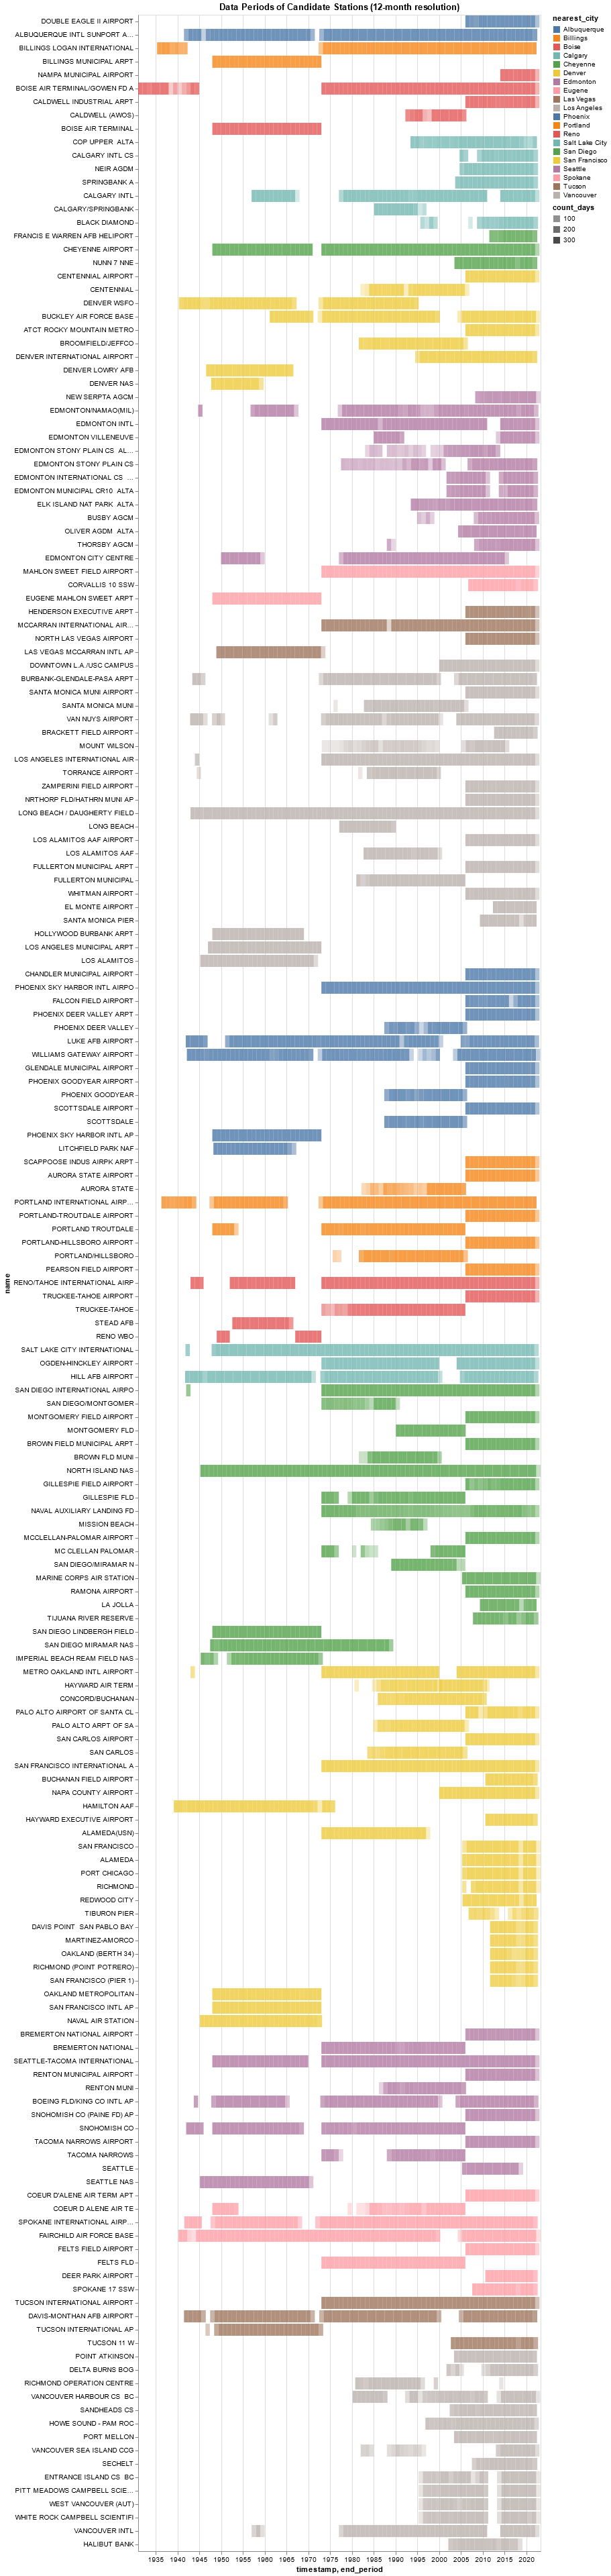

In [40]:
alt.Chart(subset_resampled.reset_index()).mark_bar().encode(
    alt.X('timestamp:T'),
    alt.X2('end_period:T'),
    alt.Y('name:N', sort='color'),
    color='nearest_city:N',
    opacity='count_days:Q',
).properties(
    title=f"Data Periods of Candidate Stations ({resolution_months}-month resolution)"
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

Text(0, 0.5, 'Years')

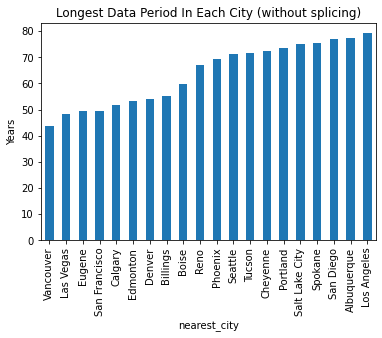

In [34]:
ax = shortlist_meta.groupby('nearest_city')['count'].max().div(365.25).sort_values().plot.bar(title="Longest Data Period In Each City (without splicing)")
ax.set_ylabel("Years")

In [35]:
raise ValueError

ValueError: 

In [ ]:
subset = subset.unstack(['wban', 'usaf']).asfreq('1d').stack(['wban', 'usaf'], dropna=False)
subset.index = subset.index.reorder_levels(order=['usaf', 'wban', 'timestamp'])
subset.sort_index(inplace=True)
subset.head()

In [36]:
shortlist_meta.loc[shortlist_meta['name'].str.startswith('CHEYENNE')]

,,min,max,count,time_coverage,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,,,,,
725640,24018,1948-01-01,2022-04-17,26405,0.973097,CHEYENNE AIRPORT,US,WY,KCYS,41.158,-104.807,1863.2,1948-01-01,2021-09-21,Cheyenne,2.290103,73.722108


<AxesSubplot:xlabel='timestamp'>

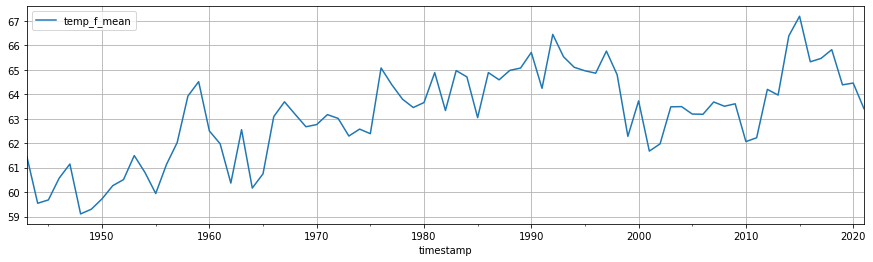

In [37]:
# Long Beach
gsod.loc[('722970', '23129'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)

<AxesSubplot:xlabel='timestamp'>

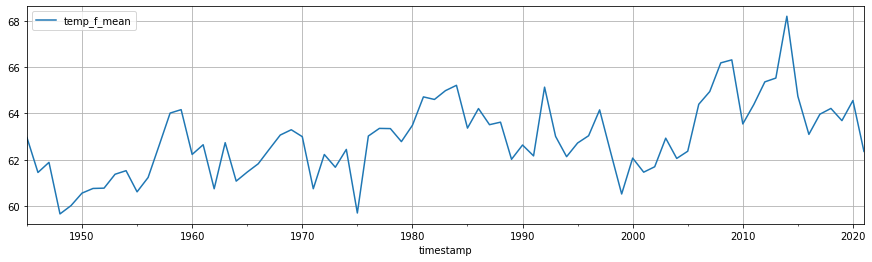

In [38]:
# North Island
gsod.loc[('722906', '93112'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)

<AxesSubplot:xlabel='timestamp'>

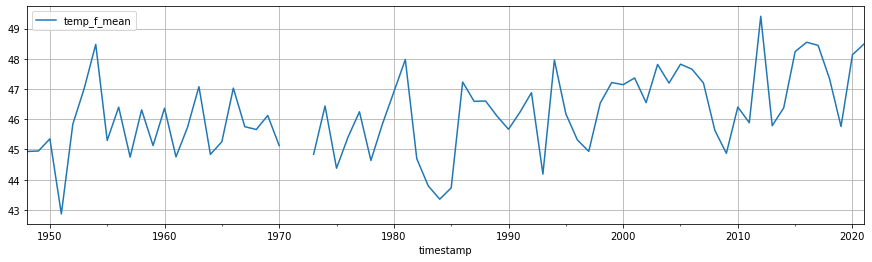

In [39]:
# Cheyenne Airport
gsod.loc[('725640', '24018'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)